In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def calc_price(phi1, phi2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    phi1, phi2 = phi1, phi2
    p1 = (2*phi1+phi2)/3. + cost
    p2 = (2*phi2+phi1)/3. + cost
    if phi1 <= 0 or phi2 <= 0:
        return 0,0
    
    return p1, p2
  
    
def calc_s(phi1, phi2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(phi1, phi2, cost, wtp)
    s_hat = .5 + (p2 - p1)/(2.*cost)
    return s_hat


def calc_profits(phi1,phi2,cost, wtp, mc):
    phi1, phi2 = phi1, phi2
    s= calc_s(phi1, phi2, cost, wtp)
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    profits1, profits2 = s*(p1-phi1), (1-s)*(p2-phi2)
    mc1,mc2 = mc
    hosp_profit = s*(phi1-mc1) +  (1-s)*(phi2-mc2)
    
    if phi1 <= 0 or phi2 <= 0:
        return 0,0,0
    
    return hosp_profit, profits1, profits2

    
def outside_simlt(phi1, phi2, cost, wtp,  mc, active=False):
    """outside option in simult case
    assuming listprice high enough"""
    mc1,mc2 = mc
    
    if active:
        return (wtp-cost)/2 - mc2 #outside cost is other insurer?

    
    s_hat = calc_s(phi1, phi2, cost, wtp) # s_hat with no recapture
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    s_hat  = np.clip((cost + p2 - wtp)/cost,0,1) #s_hat with recapture
    
    
    return (1-s_hat)*(phi2 -mc2)


calc_profits(5,0 ,5, 26, [0,0])

(0, 0, 0)

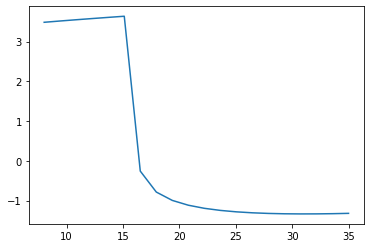

In [3]:
#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5,outside=None):
    if outside == None:
        outside = outside_simlt(phi1, phi2,cost, wtp , mc, active=True)

    hosp_profit, profits1, profits2 = calc_profits(phi1, phi2,  cost,  wtp, mc)
    obj = -1*(np.log(max(hosp_profit-outside,1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


def bargain_helper_seq(phi1, cost, wtp, mc,beta=.5):
    
    """ solve firm 1s optimization holding theta 2 fixed """
    outside = outside_simlt(phi1, None, cost, wtp, mc, active=True)
    result = minimize( nash_in_nash, 15., args=(phi1, cost, wtp, mc[::-1], beta, outside),
                      method='Nelder-Mead', options={'disp': False} )
    return result.x


def seq_obj(phi1, cost, wtp, mc, betas=np.array([.5,.5])):
    """ theta1 is a guess for the first stage """
    phi2 = bargain_helper_seq(phi1, cost, wtp, mc,betas[1])
    return nash_in_nash( phi1, phi2, cost, wtp, mc, betas[0], phi2 )


COST = 5
WTP = 25
MC = np.array([0,0])


plt.plot([i for i in np.linspace(COST+3,WTP +10,num=20)],  
         [seq_obj(i, 13.5 , WTP,MC) for i in np.linspace(COST+3,WTP +10,num=20)])

In [4]:
def seq_bargain(phi1, cost, wtp, mc, betas=[.5,.5]):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, phi1, args=(cost, wtp, mc, betas),
                      method='Nelder-Mead', options={'disp': False})
    
    phi1 = result.x
    phi2 = bargain_helper_seq(phi1, cost, wtp, mc ,beta=betas[1])
    return phi1, phi2

print(seq_bargain(30, COST, WTP, MC))

(array([19.37493896]), array([15.62493896]))


In [5]:
#firm 1 has high cost

COST = 5
WTP  = 25

print("cost1","phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,2,5):
    mc_i = np.array([i, 0])
    phi1,phi2 = seq_bargain(20,COST,WTP,mc_i)
    hosp_profit, profits1, profits2= calc_profits(phi1[0],phi2[0],COST, WTP, mc_i )
    print(i, round(phi1[0],3), round(phi2[0],3), round(hosp_profit,3), round(profits1,3), round(profits2,3))

cost1 phi 1 phi 2 hosp profit profit 1 profit 2
0.0 19.375 15.625 17.031 1.406 3.906
0.5 20.062 15.938 17.252 1.314 4.064
1.0 20.75 16.25 17.475 1.225 4.225
1.5 21.437 16.562 17.702 1.139 4.389
2.0 22.125 16.875 17.931 1.056 4.556


In [6]:
#firm 2 has high cost

COST = 5
WTP  = 25

print("cost1","phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,2,5):
    mc_i = np.array([0, i])
    phi1,phi2 = seq_bargain(20,COST,WTP,mc_i)
    hosp_profit, profits1, profits2= calc_profits(phi1[0],phi2[0],COST, WTP, mc_i )
    print(i, round(phi1[0],3), round(phi2[0],3), round(hosp_profit,3), round(profits1,3), round(profits2,3))

cost1 phi 1 phi 2 hosp profit profit 1 profit 2
0.0 19.375 15.625 17.031 1.406 3.906
0.5 19.901 15.841 17.004 1.33 4.037
1.0 20.544 16.126 17.037 1.244 4.189
1.5 21.349 16.509 17.156 1.147 4.373
2.0 22.407 17.044 17.41 1.032 4.607


In [5]:
#generate a bunch of runs with passive and compute costs

def compute_cov(nobs=1000):
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = seq_bargain(30,COST,WTP,mcs[:,i]) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False),phis

matrix, phis = compute_cov()
print(phis[:,0].max(),phis[:,0].mean(),phis[:,0].min())
print('--')
print(phis[:,1].max(),phis[:,1].mean(),phis[:,1].min())
print('--')
print(matrix)
print('--')
print(np.cov(phis[0:500,:],rowvar=False))
print('--')
print(np.cov(phis[100:600,:],rowvar=False))
print('--')
print(np.cov(phis[200:700,:],rowvar=False))
print('--')
print(np.cov(phis[300:800,:],rowvar=False))


<ipython-input-3-88a8614b017d>:8: RuntimeWarning: divide by zero encountered in log
  + np.log(profits1)*beta)
/home/erichschulman/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:734: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


26.72259521484375 22.162783996582032 7.8973388671875
--
19.284759521484375 16.999437103271486 15.543548583984375
--
[[5.00609385 1.4474487 ]
 [1.4474487  0.61745298]]
--
[[5.69691789 1.55365314]
 [1.55365314 0.64616777]]
--
[[5.25624049 1.49014542]
 [1.49014542 0.6294188 ]]
--
[[5.97207681 1.53320299]
 [1.53320299 0.6206359 ]]
--
[[4.79007795 1.41782025]
 [1.41782025 0.61025573]]


In [6]:
phis_clean = phis[phis[:,0]>=17]
print('--')
print(np.cov(phis_clean[0:500,:],rowvar=False))
print('--')
print(np.cov(phis_clean[100:600,:],rowvar=False))
print('--')
print(np.cov(phis_clean[200:700,:],rowvar=False))
print('--')
print(np.cov(phis_clean[300:800,:],rowvar=False))

--
[[2.53370986 1.26052635]
 [1.26052635 0.62794548]]
--
[[2.50492343 1.24659581]
 [1.24659581 0.62117878]]
--
[[2.38269878 1.18564796]
 [1.18564796 0.59078235]]
--
[[2.37627851 1.18104936]
 [1.18104936 0.58779138]]


In [7]:
#generate a bunch of runs with passive and compute costs

def compute_cov(nobs=1000):
    mcs = np.random.uniform(low=0.0, high=1.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = seq_bargain(30,COST,WTP,mcs[:,i]) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False),phis

matrix, phis = compute_cov()
print(phis[:,0].max(),phis[:,0].mean(),phis[:,0].min())
print('--')
print(phis[:,1].max(),phis[:,1].mean(),phis[:,1].min())
print('--')
print(matrix)
print('--')
print(np.cov(phis[0:500,:],rowvar=False))
print('--')
print(np.cov(phis[100:600,:],rowvar=False))
print('--')
print(np.cov(phis[200:700,:],rowvar=False))

22.16510009765625 20.665902465820313 19.412200927734375
--
16.9075927734375 16.201358276367188 15.639862060546875
--
[[0.33854712 0.15555262]
 [0.15555262 0.071527  ]]
--
[[0.33120504 0.15207134]
 [0.15207134 0.06987381]]
--
[[0.33420121 0.15344959]
 [0.15344959 0.07051097]]
--
[[0.35462485 0.16287168]
 [0.16287168 0.07485675]]


In [8]:
#generate a bunch of runs with passive and compute costs

def compute_cov(nobs=1000):
    mcs = np.random.uniform(low=0.0, high=.5, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = seq_bargain(30,COST,WTP,mcs[:,i]) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False),phis

matrix, phis = compute_cov()
print(phis[:,0].max(),phis[:,0].mean(),phis[:,0].min())
print('--')
print(phis[:,1].max(),phis[:,1].mean(),phis[:,1].min())
print('--')
print(matrix)
print('--')
print(np.cov(phis[0:500,:],rowvar=False))
print('--')
print(np.cov(phis[100:600,:],rowvar=False))
print('--')
print(np.cov(phis[200:700,:],rowvar=False))

20.63525390625 19.985581237792967 19.400848388671875
--
16.183685302734375 15.891907470703124 15.636199951171875
--
[[0.06861835 0.03059158]
 [0.03059158 0.01366665]]
--
[[0.07226691 0.03222809]
 [0.03222809 0.01440037]]
--
[[0.07151834 0.03193726]
 [0.03193726 0.01429117]]
--
[[0.06620515 0.02952046]
 [0.02952046 0.01319175]]


In [9]:
#just make sure it works for stuff i know is right

def compute_solution(nobs=20):
    #mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    vs = np.random.uniform(low=26,high=26.5,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    x = np.concatenate(([vs],[lambdas])) #,mcs
    for i in range(nobs):
        phi = seq_bargain(30,lambdas[i],vs[i],np.array([0,0])) 
        phis.append(np.array(phi).flatten())
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)
    
print(compute_solution(nobs=10))

(array([0.49998281, 1.37508166]), array([0.49998482, 0.62507181]))


In [10]:
def compute_solution(nobs=20):
    
    #set up x variables to solve the model
    phis = []
    vs = np.random.uniform(low=26,high=26.5,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    mcs = np.random.uniform(low=0.0, high=1.0, size=(2,nobs))
    x = np.concatenate(([vs],[lambdas],mcs))
    
    #generate a few solutions...
    for i in range(nobs):
        phi = seq_bargain(35,lambdas[i],vs[i],mcs[:,i])
        phis.append(np.array(phi).flatten())
        
    #do regression stuff to solve
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)

#coeffs are v, lambda, c1, c2
print(compute_solution(nobs=10))  

#maybe do it 10 times and take the average?

(array([0.49739751, 1.35936087, 1.53841707, 1.32517949]), array([0.49845455, 0.61553075, 0.72307295, 0.59516862]))
